<h1>Discrete Fourier Transform and Windowing</h1>

This notebook demonstrates the basics of using the Discrete Fourier Transform (DFT) with windowing.

DFT or FFT? The Fast Fourier Transform (FFT) is an efficient algorithm for computing the DFT. This means you will often find the two terms used interchangeably, especially in the context of digital (audio) signal processing.

Dependencies:
* librosa
* numpy
* scipy
* matplotlib

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import numpy as np
import scipy
from IPython.display import Audio

We start by generating a simple signal: a 1 second long (co)sine wave with a frequency of 1000 Hz:

In [2]:
sr = 44100 # sample rate
f1 = 1000 # sine frequency
x = 0.5 * np.cos(2*np.pi * f1 * np.arange(44100 * 1)/float(sr)) # is our signal

In [3]:
# We can listen to the audio signal right here in the notebook:
Audio(x, rate=sr)

Let's plot the complete signal:

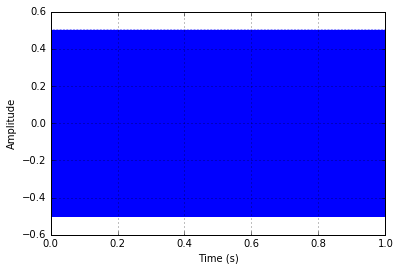

In [4]:
plt.plot(np.arange(len(x)) / float(sr), x)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

Not very helpful? That's because the signal is too dense... let's zoom in on a single frame (=group of consecutive samples):

In [5]:
frame_size = 1024 # how many samples to include in our frame

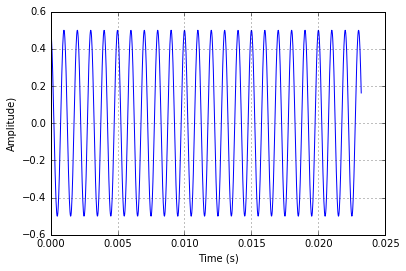

In [6]:
frame = x[:frame_size]
fig = plt.figure()
plt.plot(np.arange(frame_size)/float(sr), frame)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude)')
plt.grid()
plt.show()

In [7]:
fig.savefig('plots/fft/x.pdf')

<h2>Discrete Fourier Transform</h2>

Now we're going to take the DFT of this frame to see the periodicities in the signal represented by the amplitude of different frequencies:

In [8]:
# We compute a DFT using an FFT size that's 4 times the size of
# of our frame, filling the remaining samples with zeros. This is
# called "zero padding" and will result in a spectrum with a "higher"
# resolution on the frequecny axis, giving it a smoother shape. 
fft_size = frame_size * 4

In [9]:
# Before taking the FFT we normalize the frame so that the spectral
# amplitudes reflect the original time-domain signal amplitudes:
X = librosa.spectrum.fft.fft(frame / float(len(frame)/2), n=fft_size)

Let's plot the spectrum! There are a few interesting things to note here:
1. The x-axis values are computed from the fft size and the sampling rate
2. We need to take abs(X) (i.e. |X|) because the DFT returns a complex signal
3. We plot the magnitude values on a decibel (dB) scale by takeing 20*log10(|X|)
4. The librosa fft function returns an array that is the same size as the input array, however only the first half of the array represents non-negative frequencies (the second half represents negative frequencies and is almost always discarded). For this reason we only plot the first half of the array (and then we zoom in even further):

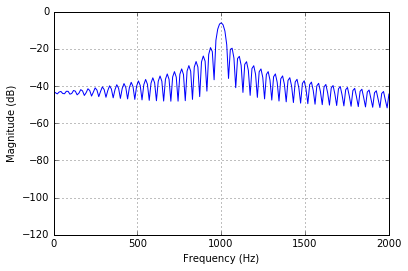

In [10]:
fig = plt.figure()
plt.plot(np.arange(fft_size//2) * sr/float(fft_size), 20*np.log10(np.abs(X[:fft_size//2])))
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.ylim(-120,0)
plt.xlim(0, 2000) # let's limit the plot between 0 and 2000 Hz
plt.grid()
plt.show()

In [11]:
fig.savefig('plots/fft/fft.pdf')

We see a peak at 1000 Hz, which corresponds to the frequency of the sine wave we generated.
However, we also see many peaks (lobes) to the left and the right of the main peak. These are
called "side lobes". They are an artifact of the processing we've performed and do not represent
real energies. Let's zoom in:

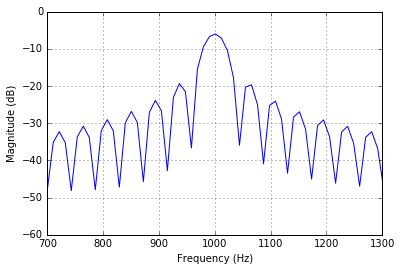

In [12]:
fig = plt.figure()
plt.plot(np.arange(fft_size//2) * sr/float(fft_size), 20*np.log10(np.abs(X[:fft_size//2])))
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.ylim(-60,0)
plt.xlim(700,1300)
plt.grid()
plt.show()

In [13]:
fig.savefig('plots/fft/lobes.pdf')

<h2>Windowing</h2>

In order to reduce the side-lobe effect, we can perform what's called "windowing". 
This process involves taking the dot product of our signal with a "window function"
in the time domain before computing the DFT (or convolving the DFT of our signal with
the DFT of the window function in the frequency domain):

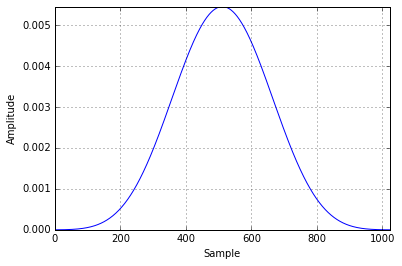

In [14]:
# Numpy provides a number of commonly used window functions.
# We're going to use the Blackman-Harris window (and normalize it)
win = scipy.signal.blackmanharris(frame_size) / (scipy.signal.blackmanharris(frame_size).sum() / 2.)
fig = plt.figure()
plt.plot(win)
plt.ylabel('Amplitude')
plt.xlabel('Sample')
plt.axis('tight')
plt.grid()
plt.show()

In [15]:
fig.savefig('plots/fft/win.pdf')

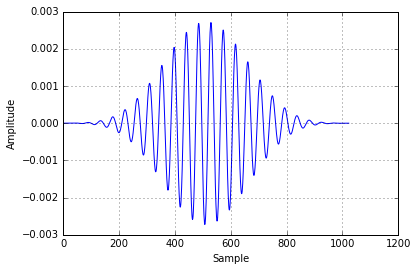

In [16]:
# Now we're going to window our frame:
xwin = frame * win
fig = plt.figure()
plt.plot(xwin)
plt.ylabel('Amplitude')
plt.xlabel('Sample')
plt.grid()
plt.show()

In [17]:
fig.savefig('plots/fft/xwin.pdf')

In [18]:
# Finally let's compute the DFT of our windowed frame
Xwin = librosa.spectrum.fft.fft(xwin, n=fft_size)

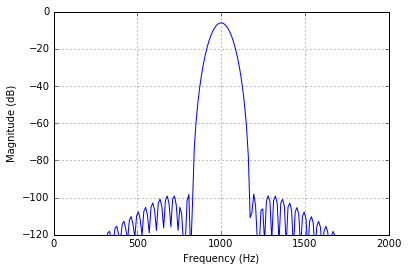

In [19]:
fig = plt.figure()
plt.plot(np.arange(fft_size//2) * sr/float(fft_size), 20*np.log10(np.abs(Xwin[:fft_size//2])))
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 2000)
plt.ylim(-120,0)
plt.grid()
plt.show()

In [20]:
fig.savefig('plots/fft/fftwin.pdf')

We can see that the main lobe is much higher compared to the side-lobes now:
without windowing (which is equivalent to windowing using a rectangular window)
the side lobes were less than 20 dB below the main lobe, now the difference between
the main lobe and the side lobes is over 90 dB: a cleaner representation!

## Comparison

Finally, let's compare everything in one plot: the first row shows the process of obtaining the spectrum using a rectangular window, and the second row shows the same process but using a Blackman window.

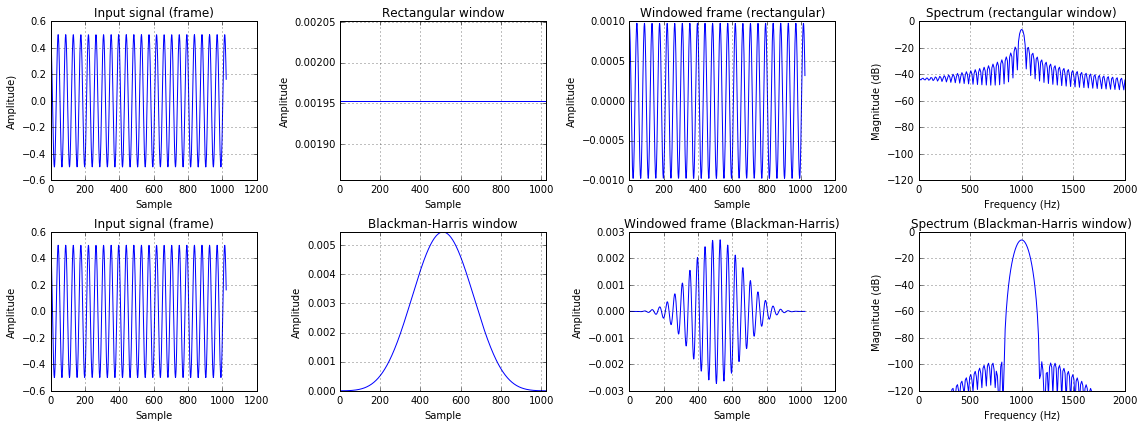

In [21]:
fig = plt.figure(figsize=(16,6))

# Input signal (frame)
ax = fig.add_subplot(241)
plt.plot(frame)
plt.xlabel('Sample')
plt.ylabel('Amplitude)')
plt.grid()
plt.title('Input signal (frame)')

# Rectangular window
rect_win = np.ones(frame_size) / (frame_size / 2.)
ax = fig.add_subplot(242)
plt.plot(rect_win)
plt.ylabel('Amplitude')
plt.xlabel('Sample')
plt.axis('tight')
plt.grid()
plt.title('Rectangular window')

# Frame with square window (equivalent to no window)
ax = fig.add_subplot(243)
plt.plot(frame * rect_win)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid()
plt.title('Windowed frame (rectangular)')

# Spectrum of frame windowed with a rectangular window (=no windowing)
ax = fig.add_subplot(244)
plt.plot(np.arange(fft_size//2) * sr/float(fft_size), 20*np.log10(np.abs(X[:fft_size//2])))
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.ylim(-120,0)
plt.xlim(0, 2000) # let's limit the plot between 0 and 2000 Hz
plt.grid()
plt.title('Spectrum (rectangular window)')

# Input signal (frame)
ax = fig.add_subplot(245)
plt.plot(frame)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid()
plt.title('Input signal (frame)')

# Blackman window
ax = fig.add_subplot(246)
plt.plot(win)
plt.ylabel('Amplitude')
plt.xlabel('Sample')
plt.axis('tight')
plt.grid()
plt.title('Blackman-Harris window')

# Windowed signal (blackman)
ax = fig.add_subplot(247)
plt.plot(xwin)
plt.ylabel('Amplitude')
plt.xlabel('Sample')
plt.grid()
plt.title('Windowed frame (Blackman-Harris)')

# Spectrum (blackman)
ax = fig.add_subplot(248)
plt.plot(np.arange(fft_size//2) * sr/float(fft_size), 20*np.log10(np.abs(Xwin[:fft_size//2])))
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 2000)
plt.ylim(-120,0)
plt.grid()
plt.title('Spectrum (Blackman-Harris window)')

plt.tight_layout()
plt.show()

In [22]:
fig.savefig('plots/fft/everything.pdf')